<div style="
  padding: 18px 24px;
  margin-top: 15px;
  margin-bottom: 25px;
  border-left: 6px solid var(--jp-info-color0);
  background: var(--jp-layout-color2);
  border-radius: 8px;
">
<h1 style="margin:0; color:var(--jp-ui-font-color1);">
04. Exploratory Data Analysis
</h1>
<p style="font-size: 1.1em; color: var(--jp-ui-font-color1); margin-top: 6px;">
Разведочный анализ данных
</p>
</div>


<h2 style="
  padding: 6px 0;
  border-bottom: 2px solid var(--jp-border-color2);
  /* color: var(--jp-ui-font-color1); */
  margin-top: 32px;
">
04.1 Корреляционная матрица phi k
</h2>

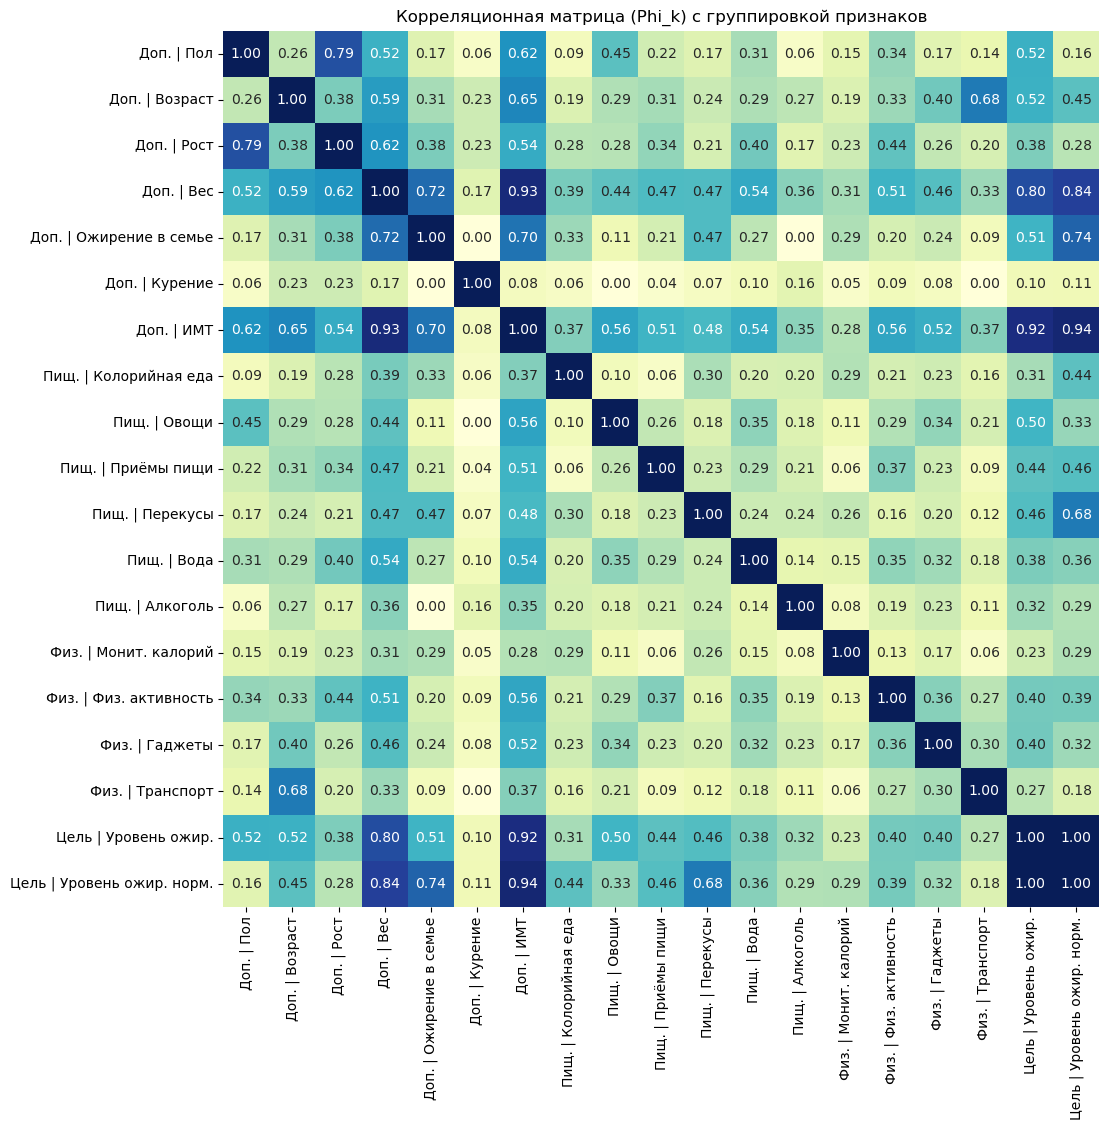

**Очень высокая взаимная корреляция (>= 0.8):**

,Признак 1,Признак 2,Phi_k
170,Уровень ожир.,Уровень ожир. норм.,1.000000
104,ИМТ,Уровень ожир. норм.,0.942365
53,Вес,ИМТ,0.927799
103,ИМТ,Уровень ожир.,0.917347
65,Вес,Уровень ожир. норм.,0.840256


**Кандидаты по корреляции с таргетом (Уровень ожир. норм.) (>= 0.3):**

,Phi_k
Уровень ожир.,1.000000
ИМТ,0.942365
Вес,0.840256
Ожирение в семье,0.735282
Перекусы,0.680178
Приёмы пищи,0.459006
Возраст,0.448504
Колорийная еда,0.441892
Физ. активность,0.392347
Вода,0.359648


**Слабых признаков по критерию Phi_k < 0.15 не найдено.**

In [1]:
import seaborn as sns
import phik
import matplotlib.pyplot as plt
import numpy as np
from utils import load_clean_df, load_columns_mapping

# Корреляционная матрица Phi_k с группировкой по mapping
df_named = load_clean_df("short_ru")

numeric_short_columns = df_named.select_dtypes(include=["number"]).columns.tolist()
phik_matrix = df_named.phik_matrix(interval_cols=numeric_short_columns)

columns_mapping = load_columns_mapping()

# Порядок групп из маппинга (если задан) либо дефолтный
ordered_groups = columns_mapping.get("groups_order", [])
if not ordered_groups:
    ordered_groups = [
        "Признаки пищевых привычек",
        "Признаки физического состояния",
        "Дополнительные переменные",
        "Целевая переменная",
    ]

# Строим словарь групп для любых вариантов названий (оригинал/short_ru/description)
group_map = {}
for orig, meta in columns_mapping.items():
    if not isinstance(meta, dict):
        continue
    group = meta.get("short_group_ru", meta.get("group_ru", "Прочие признаки"))
    for label in (orig, meta.get("short_ru"), meta.get("description_ru"), meta.get("description_en")):
        if label:
            group_map[label] = group

get_group = lambda col: group_map.get(col, "Прочие признаки")

# Дополняем порядком для всех встречающихся групп
ordered_groups += [g for g in sorted({get_group(c) for c in phik_matrix.columns}) if g not in ordered_groups]

ordered_cols = []
for g in ordered_groups:
    ordered_cols.extend([c for c in phik_matrix.columns if get_group(c) == g])

phik_matrix = phik_matrix.loc[ordered_cols, ordered_cols]
display_labels = [f"{get_group(col)} | {col}" for col in ordered_cols]

plt.figure(figsize=(max(12, 1.2 * len(phik_matrix)), max(8, 0.6 * len(phik_matrix))))
sns.heatmap(
    phik_matrix,
    cmap="YlGnBu",
    vmin=0,
    vmax=1,
    square=True,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Phi_k"},
    xticklabels=display_labels,
    yticklabels=display_labels,
    cbar=False,
)
plt.title("Корреляционная матрица (Phi_k) с группировкой признаков")
plt.tight_layout()
plt.show()

# --- Выгрузка по категориям корреляций ---
from IPython.display import Markdown

target_key = "NObeyesdad_norm"
meta_target = columns_mapping.get(target_key, {})
target_col = None
for label in (meta_target.get("short_ru"), meta_target.get("description_ru"), meta_target.get("description_en"), target_key):
    if label and label in phik_matrix.columns:
        target_col = label
        break

if target_col:
    # 1) Очень высокая взаимная корреляция (>= 0.8)
    upper = phik_matrix.where(np.triu(np.ones(phik_matrix.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "Признак 1", "level_1": "Признак 2", 0: "Phi_k"})
    )
    high_pairs = pairs[pairs["Phi_k"] >= 0.8].sort_values("Phi_k", ascending=False)
    if not high_pairs.empty:
        display(Markdown("**Очень высокая взаимная корреляция (>= 0.8):**"))
        display(high_pairs.head(10))
    else:
        display(Markdown("**Очень высокая взаимная корреляция (>= 0.8): не обнаружена.**"))

    # 2) Средняя/высокая корреляция с таргетом
    target_corr = (
        phik_matrix[target_col]
        .drop(target_col, errors="ignore")
        .sort_values(ascending=False)
    )
    target_top = target_corr[target_corr >= 0.3]
    if not target_top.empty:
        display(Markdown(f"**Кандидаты по корреляции с таргетом ({target_col}) (>= 0.3):**"))
        display(target_top.to_frame("Phi_k"))
    else:
        display(Markdown("**Кандидаты по корреляции с таргетом (>= 0.3): не обнаружено.**"))

    # 3) Слабые признаки: низкая корреляция с таргетом и остальными
    weak_features = []
    for col in phik_matrix.columns:
        if col == target_col:
            continue
        row_vals = phik_matrix.loc[col].drop(col)
        max_corr = row_vals.max()
        target_corr_val = phik_matrix.loc[col, target_col]
        if max_corr < 0.15 and target_corr_val < 0.15:
            weak_features.append((col, max_corr, target_corr_val))
    if weak_features:
        weak_df = pd.DataFrame(weak_features, columns=["Признак", "Макс Phi_k с любым", f"Phi_k с {target_col}"])
        weak_df = weak_df.sort_values(f"Phi_k с {target_col}")
        display(Markdown("**Слабые признаки (макс Phi_k < 0.15 со всеми и таргетом):**"))
        display(weak_df)
    else:
        display(Markdown("**Слабых признаков по критерию Phi_k < 0.15 не найдено.**"))


<div style="
  border-left: 4px solid var(--jp-warn-color0);
  background: var(--jp-layout-color2);
  padding: 12px 14px;
  border-radius: 6px;
  margin: 12px 0;
  color: var(--jp-ui-font-color1);
">
<strong>⚠️ Предупреждение:</strong><br>
Индекс массы тела имеет огромную предсказательную силу. Поэтому при моделировании стараться сделать так, чтобы либо дополнительные показатели увеличивали качество модели, либо попробовать отказаться от использования ИМТ (BMI).
</div>


<div style="
  border-left: 4px solid var(--jp-success-color0);
  background: var(--jp-layout-color2);
  padding: 12px 14px;
  border-radius: 6px;
  margin: 12px 0;
  color: var(--jp-ui-font-color1);
">
<strong>✅ Вывод:</strong><br>
Кроме ИМТ, необходимо попробовать обучить модель на следующих показателях:

- Ожирение в семье
- Перекусы
- Приёмы пищи
- Возраст
- Колорийная еда
- Физ. активность
- Вода
- Овощи
- Гаджеты
</div>


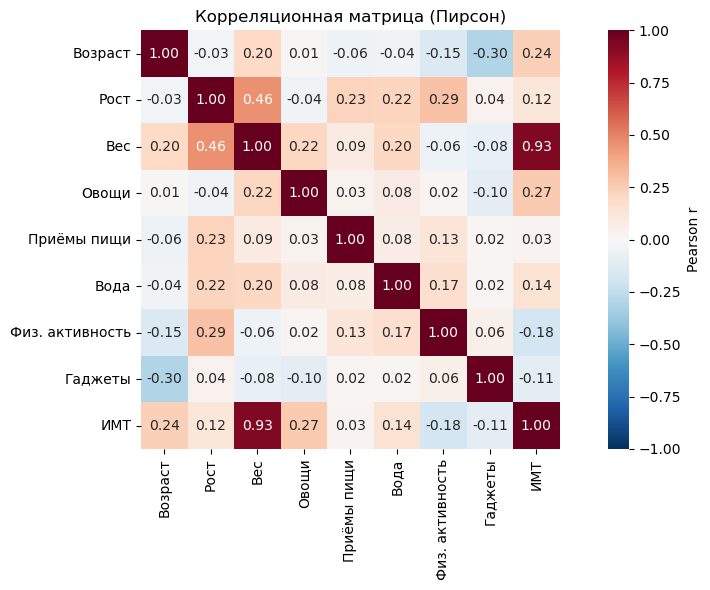

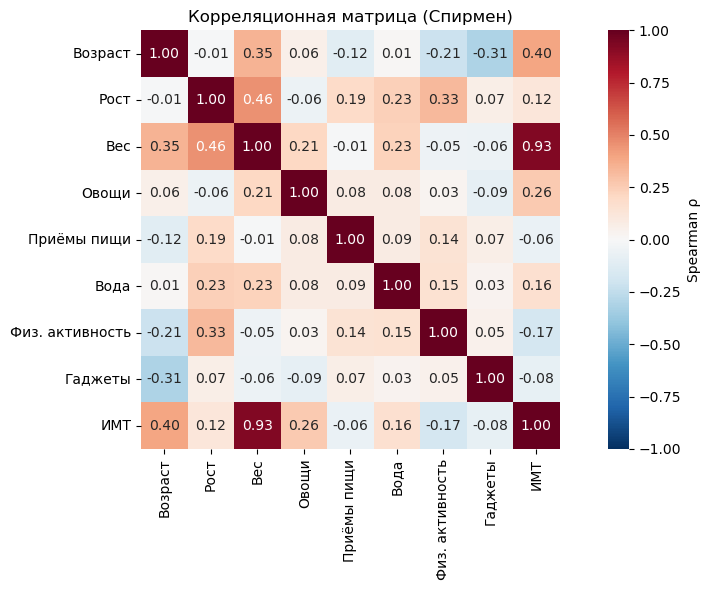

**Пары с наибольшей разницей между Spearman и Pearson (|Δ| ≥ 0.05):**

,Признак 1,Признак 2,Pearson r,Spearman ρ,Δ|ρ|-|r|
7,Возраст,ИМТ,0.240769,0.395308,0.154539
1,Возраст,Вес,0.198160,0.350296,0.152135
5,Возраст,Физ. активность,-0.148202,-0.212920,0.064718
3,Возраст,Приёмы пищи,-0.055823,-0.116660,0.060837
28,Приёмы пищи,Гаджеты,0.015693,0.068211,0.052518
16,Вес,Приёмы пищи,0.092149,-0.011708,-0.080442


**Сильные связи (|r| ≥ 0.7, Пирсон):**

,Признак 1,Признак 2,Pearson r
20,Вес,ИМТ,0.934494


**Сильные связи (|ρ| ≥ 0.7, Спирмен):**

,Признак 1,Признак 2,Spearman ρ
20,Вес,ИМТ,0.929184


**Умеренные связи (0.2 ≤ |r| < 0.7, Пирсон):**

,Признак 1,Признак 2,Pearson r
8,Рост,Вес,0.457468
12,Рост,Физ. активность,0.293584
25,Овощи,ИМТ,0.265082
7,Возраст,ИМТ,0.240769
10,Рост,Приёмы пищи,0.227806
11,Рост,Вода,0.220487
15,Вес,Овощи,0.216574
17,Вес,Вода,0.203823
6,Возраст,Гаджеты,-0.302927


**Умеренные связи (0.2 ≤ |ρ| < 0.7, Спирмен):**

,Признак 1,Признак 2,Spearman ρ
8,Рост,Вес,0.456129
7,Возраст,ИМТ,0.395308
1,Возраст,Вес,0.350296
12,Рост,Физ. активность,0.326988
25,Овощи,ИМТ,0.264084
11,Рост,Вода,0.234442
17,Вес,Вода,0.230414
15,Вес,Овощи,0.209576
5,Возраст,Физ. активность,-0.212920
6,Возраст,Гаджеты,-0.306113


In [5]:
import seaborn as sns
import pandas as pd

numeric_only = df_named.apply(pd.to_numeric, errors="coerce")
numeric_only = numeric_only.dropna(axis=1, how="all")
pearson_corr = numeric_only.corr(method="pearson")

plt.figure(figsize=(10, 6))
sns.heatmap(
    pearson_corr,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("Корреляционная матрица (Пирсон)")
plt.tight_layout()
plt.show()

# Матрица Спирмена (монотонные связи, устойчивее к выбросам)
spearman_corr = numeric_only.corr(method="spearman")
plt.figure(figsize=(10, 6))
sns.heatmap(
    spearman_corr,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"label": "Spearman ρ"},
)
plt.title("Корреляционная матрица (Спирмен)")
plt.tight_layout()
plt.show()

# Сравнение пар (Pearson vs Spearman)
from IPython.display import Markdown

cols = list(numeric_only.columns)


def pairs_from_corr(corr_df, metric_name):
    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            pairs.append({
                "Признак 1": cols[i],
                "Признак 2": cols[j],
                metric_name: corr_df.iloc[i, j],
            })
    return pd.DataFrame(pairs)

pearson_pairs = pairs_from_corr(pearson_corr, "Pearson r")
spearman_pairs = pairs_from_corr(spearman_corr, "Spearman ρ")

compare = pearson_pairs.merge(spearman_pairs, on=["Признак 1", "Признак 2"])
compare["Δ|ρ|-|r|"] = compare["Spearman ρ"].abs() - compare["Pearson r"].abs()

# Пары с наибольшей разницей (порог 0.05 — небольшая, но заметная)
diff_threshold = 0.05
largest_diffs = compare[compare["Δ|ρ|-|r|"].abs() >= diff_threshold]
largest_diffs = largest_diffs.sort_values("Δ|ρ|-|r|", ascending=False)
if not largest_diffs.empty:
    display(Markdown("**Пары с наибольшей разницей между Spearman и Pearson (|Δ| ≥ 0.05):**"))
    display(largest_diffs.head(10))
else:
    display(Markdown("**Заметных различий между Spearman и Pearson (|Δ| ≥ 0.05) не обнаружено.**"))

# Сильные и умеренные связи
strong_threshold = 0.7
moderate_low, moderate_high = 0.2, 0.7

strong_pearson = pearson_pairs[pearson_pairs["Pearson r"].abs() >= strong_threshold].sort_values("Pearson r", ascending=False)
strong_spearman = spearman_pairs[spearman_pairs["Spearman ρ"].abs() >= strong_threshold].sort_values("Spearman ρ", ascending=False)
moderate_pearson = pearson_pairs[(pearson_pairs["Pearson r"].abs() >= moderate_low) & (pearson_pairs["Pearson r"].abs() < moderate_high)].sort_values("Pearson r", ascending=False)
moderate_spearman = spearman_pairs[(spearman_pairs["Spearman ρ"].abs() >= moderate_low) & (spearman_pairs["Spearman ρ"].abs() < moderate_high)].sort_values("Spearman ρ", ascending=False)

if not strong_pearson.empty:
    display(Markdown("**Сильные связи (|r| ≥ 0.7, Пирсон):**"))
    display(strong_pearson.head(10))
if not strong_spearman.empty:
    display(Markdown("**Сильные связи (|ρ| ≥ 0.7, Спирмен):**"))
    display(strong_spearman.head(10))
if not moderate_pearson.empty:
    display(Markdown("**Умеренные связи (0.2 ≤ |r| < 0.7, Пирсон):**"))
    display(moderate_pearson.head(10))
if not moderate_spearman.empty:
    display(Markdown("**Умеренные связи (0.2 ≤ |ρ| < 0.7, Спирмен):**"))
    display(moderate_spearman.head(10))


<div style="
  border-left: 4px solid var(--jp-success-color0);
  background: var(--jp-layout-color2);
  padding: 12px 14px;
  border-radius: 6px;
  margin: 12px 0;
  color: var(--jp-ui-font-color1);
">
<strong>✅ Вывод:</strong><br>
Анализ числовых показателей по Спирмену и Пирсену показал, что при обучении наилучший результат даст показатель частоты употребления овощей, но зависимость ИМТ от него небольшая 0.26
</div>
